1. Загрузка и подготовка данных...

2. Создание временных лагов и признаков...


C:\Users\Mi\AppData\Local\Temp\ipykernel_24660\1149462808.py:21: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_data = data.resample('M', on='service_date').agg({



4. Обучение моделей...


C:\Users\Mi\AppData\Local\Temp\ipykernel_24660\1149462808.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['rf_forecast'] = rf_model.predict(X_test)



Метрики качества моделей:
Метрика     Значение        Модель
    MAE 1.078355e+07 Random Forest
    MSE 1.259629e+14 Random Forest
   RMSE 1.122332e+07 Random Forest
   MAPE 8.635283e+00 Random Forest
    MAE 1.374221e+07      CatBoost
    MSE 2.125319e+14      CatBoost
   RMSE 1.457847e+07      CatBoost
   MAPE 1.096070e+01      CatBoost

Результаты теста Льюнга-Бокса:
       Модель  p-value              Вывод
Random Forest 0.107255 Нет автокорреляции
     CatBoost 0.140751 Нет автокорреляции


C:\Users\Mi\AppData\Local\Temp\ipykernel_24660\1149462808.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['cb_forecast'] = cb_model.predict(X_test)


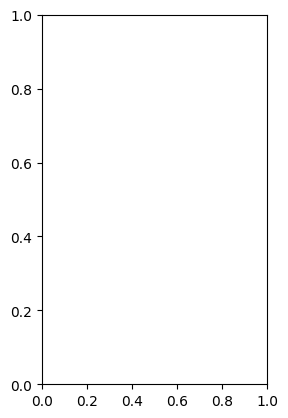

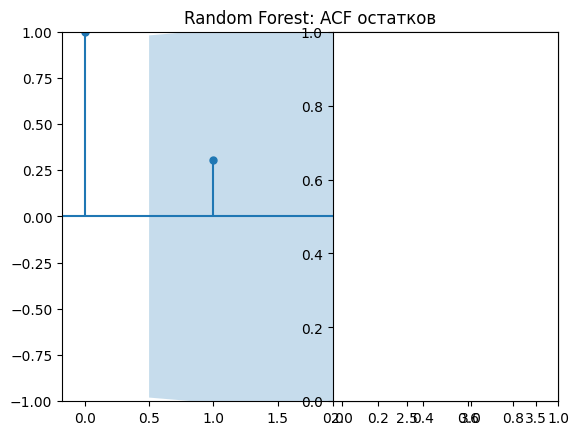

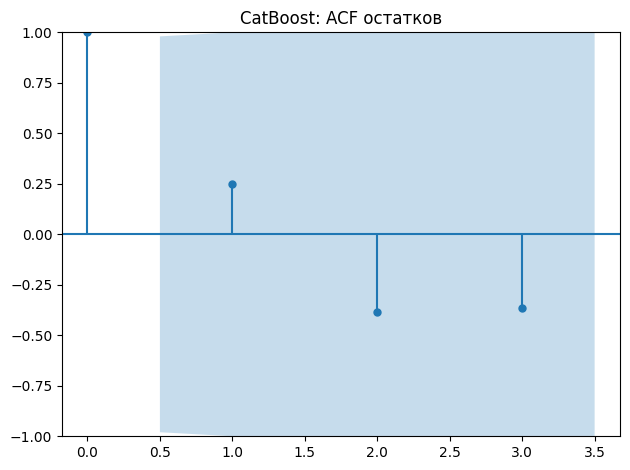

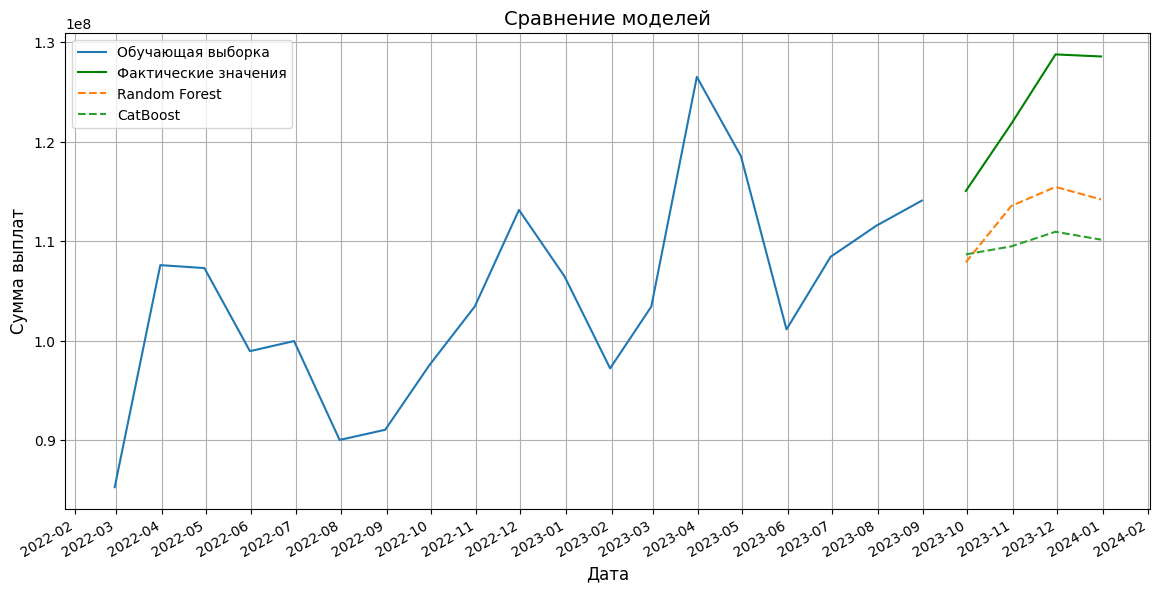

c:\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Python312\Lib\site-packages\sklearn\utils\validation.py:2

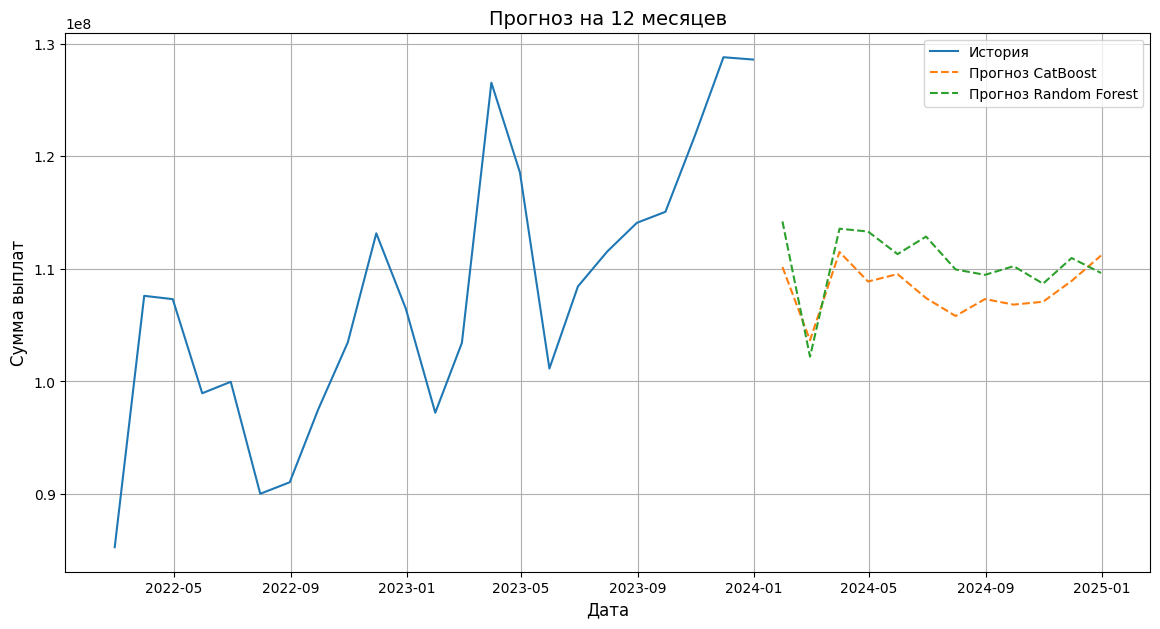

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_acf
from copy import deepcopy

# 1. Загрузка и подготовка данных
print("1. Загрузка и подготовка данных...")
data = pd.read_csv(r"D:\repositories\cup_it_25\CupIT_Sber_data.csv", delimiter=";", decimal=',')
data['service_amount_net'] = pd.to_numeric(data['service_amount_net'], errors='coerce')
data['service_date'] = pd.to_datetime(data['service_date'], errors='coerce')
data = data.dropna(subset=['service_date', 'service_amount_net'])

# 2. Создание временных лагов и признаков
print("\n2. Создание временных лагов и признаков...")
monthly_data = data.resample('M', on='service_date').agg({
    'service_amount_net': 'sum',
    'service_document_id': 'count',
    'patient_id': 'nunique'
}).rename(columns={
    'service_document_id': 'transactions_count',
    'patient_id': 'unique_patients'
})

# Лаги и скользящие статистики
lags = [1, 2, 3, 6, 9, 12]
for lag in lags:
    monthly_data[f'lag_{lag}'] = monthly_data['service_amount_net'].shift(lag)

rolling_windows = [3, 6, 12]
for window in rolling_windows:
    monthly_data[f'rolling_mean_{window}'] = monthly_data['service_amount_net'].rolling(window).mean()
    monthly_data[f'rolling_std_{window}'] = monthly_data['service_amount_net'].rolling(window).std()

# Категориальные и временные признаки
monthly_data['month'] = monthly_data.index.month.astype(str)  # Для CatBoost
monthly_data['quarter'] = monthly_data.index.quarter.astype(str)  # Для CatBoost
monthly_data['year'] = monthly_data.index.year
monthly_data['days_in_month'] = monthly_data.index.days_in_month
monthly_data['sin_month'] = np.sin(2 * np.pi * monthly_data.index.month / 12)
monthly_data['cos_month'] = np.cos(2 * np.pi * monthly_data.index.month / 12)

monthly_data = monthly_data.dropna(thresh=len(monthly_data.columns)//2)

# 3. Разделение данных
test_size = max(3, int(len(monthly_data) * 0.2))
train = monthly_data.iloc[:-test_size]
test = monthly_data.iloc[-test_size:]

X_train = train.drop('service_amount_net', axis=1)
y_train = train['service_amount_net']
X_test = test.drop('service_amount_net', axis=1)
y_test = test['service_amount_net']

# 4. Обучение моделей
print("\n4. Обучение моделей...")

# Random Forest
rf_model = RandomForestRegressor(
    n_estimators=200,
    max_depth=7,
    min_samples_split=5,
    random_state=42
)
rf_model.fit(X_train, y_train)
test['rf_forecast'] = rf_model.predict(X_test)

# CatBoost
cat_features = ['month', 'quarter']
cb_model = CatBoostRegressor(
    iterations=500,
    depth=6,
    learning_rate=0.05,
    random_seed=42,
    cat_features=cat_features,
    verbose=0
)
cb_model.fit(X_train, y_train)
test['cb_forecast'] = cb_model.predict(X_test)

# 5. Метрики качества
def calculate_metrics(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
    metrics_df = pd.DataFrame({
        'Метрика': ['MAE', 'MSE', 'RMSE', 'MAPE'],
        'Значение': [mae, mse, rmse, mape],
        'Модель': model_name
    })
    return metrics_df

rf_metrics = calculate_metrics(y_test, test['rf_forecast'], "Random Forest")
cb_metrics = calculate_metrics(y_test, test['cb_forecast'], "CatBoost")

metrics = pd.concat([rf_metrics, cb_metrics])
print("\nМетрики качества моделей:")
print(metrics.to_string(index=False))

# 6. Тест Льюнга-Бокса
def perform_ljung_box_test(residuals, model_name):
    max_lags = min(12, len(residuals)-1)
    if max_lags > 0:
        lb_test = acorr_ljungbox(residuals, lags=max_lags, return_df=True)
        p_value = lb_test['lb_pvalue'].iloc[-1]
        
        test_result = {
            'Модель': model_name,
            'p-value': p_value,
            'Вывод': 'Нет автокорреляции' if p_value > 0.05 else 'Есть автокорреляция'
        }
        return test_result

ljung_results = [
    perform_ljung_box_test(y_test - test['rf_forecast'], "Random Forest"),
    perform_ljung_box_test(y_test - test['cb_forecast'], "CatBoost")
]

print("\nРезультаты теста Льюнга-Бокса:")
print(pd.DataFrame(ljung_results).to_string(index=False))

# 7. Визуализация остатков

plt.subplot(1, 2, 1)
plot_acf(y_test - test['rf_forecast'], lags=min(12, len(test)-1), alpha=0.05)
plt.title('Random Forest: ACF остатков')

plt.subplot(1, 2, 2)
plot_acf(y_test - test['cb_forecast'], lags=min(12, len(test)-1), alpha=0.05)
plt.title('CatBoost: ACF остатков')
plt.tight_layout()
plt.show()

# 8. Сравнение моделей на графике
plt.figure(figsize=(14, 7))
plt.plot(train.index, train['service_amount_net'], label='Обучающая выборка')
plt.plot(test.index, y_test, label='Фактические значения', color='green')
plt.plot(test.index, test['rf_forecast'], label='Random Forest', linestyle='--')
plt.plot(test.index, test['cb_forecast'], label='CatBoost', linestyle='--')

plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=max(1, len(monthly_data)//12)))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gcf().autofmt_xdate()

plt.title('Сравнение моделей', fontsize=14)
plt.xlabel('Дата', fontsize=12)
plt.ylabel('Сумма выплат', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

# 9. Прогнозирование на будущие периоды
def make_forecast(model, initial_data, features, steps=12):
    forecast = []
    current_data = initial_data.copy()
    
    for _ in range(steps):
        if isinstance(model, CatBoostRegressor):
            # Для CatBoost преобразуем категориальные признаки
            input_data = pd.DataFrame([current_data], columns=features)
            for feat in model.get_cat_feature_indices():
                col = features[feat]
                input_data[col] = input_data[col].astype(str)
            pred = model.predict(input_data)[0]
        else:
            pred = model.predict([current_data])[0]
        
        forecast.append(pred)
        current_data = current_data[1:] + [pred]  # Упрощенное обновление
    
    return forecast

if len(monthly_data) >= 12:
    last_features = monthly_data.iloc[-1].drop('service_amount_net').values
    feature_names = X_train.columns.tolist()
    
    # Прогноз для CatBoost
    cb_forecast = make_forecast(cb_model, list(last_features), feature_names)
    
    # Прогноз для Random Forest
    rf_forecast = make_forecast(rf_model, list(last_features), feature_names)
    
    # Визуализация
    forecast_dates = pd.date_range(
        start=monthly_data.index[-1] + pd.offsets.MonthBegin(1),
        periods=12,
        freq='M'
    )
    
    plt.figure(figsize=(14, 7))
    plt.plot(monthly_data.index, monthly_data['service_amount_net'], label='История')
    plt.plot(forecast_dates, cb_forecast, label='Прогноз CatBoost', linestyle='--')
    plt.plot(forecast_dates, rf_forecast, label='Прогноз Random Forest', linestyle='--')
    
    plt.title('Прогноз на 12 месяцев', fontsize=14)
    plt.xlabel('Дата', fontsize=12)
    plt.ylabel('Сумма выплат', fontsize=12)
    plt.legend()
    plt.grid(True)
    plt.show()